next up is cutting down the size of the universe - i dont have an algo and its probably not smart to be click trading 50 something positions a day

going to use rolling volume to create groups and see if some outperform others, note that of course id like to find better signals but the main goal here is practicality - i just need to cut down the workload so its manageble to trade

In [1]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [2]:
# define constants
RETURNS_LOOKBACK = 30
TARGET_VOLATILITY = 1/math.sqrt(365)
print(TARGET_VOLATILITY)

0.052342392259021375


important thing to note here that im using median volatility - its from the same logic as why i check outliers dont completely control returns; if theres another trump coin that pulls all liquidity out of the market for a day and im using rolling mean/sum i get dragged more by the outlier than if i use median

i cant use median for returns as you cant trade a median return but i can do it here

In [3]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

# asset returns and funding volatility
df["rolling_returns_funding_vol"] = (
    df.groupby("asset")["returns_funding"]
      .rolling(window=RETURNS_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# creating dollar volume
df["dollar_volume"] = df["volume"] * df["close"]

# rolling median volume
df["rolling_volume"] = (
    df.groupby("asset")["dollar_volume"]
      .rolling(window=RETURNS_LOOKBACK)
      .median()
      .reset_index(level=0, drop=True)
)

# check work
df.iloc[50:56].head()

,timestamp,asset,open,high,low,close,volume,funding,funding inaccurate,returns,returns_funding,next_returns_funding,rolling_returns_funding_vol,dollar_volume,rolling_volume
50,2025-01-25 20:00:00,1000BONK-USD,0.029637,0.029813,0.028716,0.029260,574900.0,-0.000037,24,-0.012721,-0.012684,-0.154063,0.075372,16821.5740,22175.4006
51,2025-01-26 20:00:00,1000BONK-USD,0.029260,0.029260,0.024299,0.024748,1239300.0,-0.000141,24,-0.154204,-0.154063,0.008947,0.080323,30670.1964,22175.4006
52,2025-01-27 20:00:00,1000BONK-USD,0.024748,0.026785,0.024748,0.024954,982400.0,-0.000623,24,0.008324,0.008947,-0.001621,0.079880,24514.8096,22511.5796
53,2025-01-28 20:00:00,1000BONK-USD,0.024954,0.025741,0.022771,0.024913,1317900.0,-0.000022,24,-0.001643,-0.001621,0.014194,0.079750,32832.8427,22856.8046
54,2025-01-29 20:00:00,1000BONK-USD,0.024913,0.026438,0.023934,0.025254,1091300.0,-0.000506,24,0.013688,0.014194,-0.012058,0.079690,27559.6902,22856.8046


In [4]:
# creating funding signals

for i in [3, 5, 10, 15, 25, 40, 55]:
    
    df[f"funding_sig_1v{i}"] = (
    df.groupby("asset")["funding"]
      .rolling(window=i)
      .mean()
      .reset_index(level=0, drop=True)
    )

    df[f"funding_sig_2v{i}"] = df["funding"] - df[f"funding_sig_1v{i}"]

df = df.drop(columns = ["funding_sig_1v40", "funding_sig_1v55"])

In [5]:
# scaling returns and funding by volatility
df["returns_funding_volscaled"] = df["returns_funding"]*(TARGET_VOLATILITY/df["rolling_returns_funding_vol"])

# next day asset returns and funding scaled by volatility
df["next_returns_funding_volscaled"] = (
    df.groupby("asset")["returns_funding_volscaled"]
      .shift(-1)
)

# editing to remove what wont yet include a volatility scale and final day
df = df[df.groupby('asset').cumcount() > 55].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate, returns, returns_funding, next_returns_funding, rolling_returns_funding_vol, dollar_volume, rolling_volume, funding_sig_1v3, funding_sig_2v3, funding_sig_1v5, funding_sig_2v5, funding_sig_1v10, funding_sig_2v10, funding_sig_1v15, funding_sig_2v15, funding_sig_1v25, funding_sig_2v25, funding_sig_2v40, funding_sig_2v55, returns_funding_volscaled, next_returns_funding_volscaled]
Index: []

[0 rows x 29 columns]


In [6]:
idx_max = df["next_returns_funding_volscaled"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding_volscaled"].idxmin()
print(df.loc[idx_min])

timestamp                         2025-02-28 20:00:00
asset                                         ADA-USD
open                                            0.636
high                                           0.6517
low                                            0.6282
close                                          0.6424
volume                                         1560.0
funding                                     -0.000301
funding inaccurate                                 24
returns                                      0.010063
returns_funding                              0.010364
next_returns_funding                         0.620888
rolling_returns_funding_vol                  0.042673
dollar_volume                                1002.144
rolling_volume                              1724.8026
funding_sig_1v3                              0.000526
funding_sig_2v3                             -0.000827
funding_sig_1v5                              0.000498
funding_sig_2v5             

In [7]:
corr_signals = ['funding_sig_1v15', 'funding_sig_1v10', 'funding_sig_2v40', 
                'funding_sig_2v25', 'funding_sig_2v55']

df["avg_signal"] = 0

df["avg_signal"] = df[corr_signals].mean(axis=1)

In [8]:
# create deciles
df["avgsignal_decile"] = 0

# per day deciles across all assets
df['avgsignal_decile'] = df.groupby('timestamp')['avg_signal'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

df["volume_decile"] = 0

# per day deciles across all assets
df['volume_decile'] = df.groupby('timestamp')['rolling_volume'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 3, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
56    2025-01-31 20:00:00  1000BONK-USD       0.024936       0.025613   
472   2025-01-31 20:00:00  1000PEPE-USD       0.014007       0.014258   
762   2025-01-31 20:00:00  1000SHIB-USD       0.018872       0.019227   
1411  2025-01-31 20:00:00       ADA-USD       0.945700       0.954300   
1852  2025-01-31 20:00:00       ARB-USD       0.649000       0.651800   
2271  2025-01-31 20:00:00      AVAX-USD      34.720000      35.070000   
2909  2025-01-31 20:00:00       BNB-USD     679.200000     681.400000   
3332  2025-01-31 20:00:00       BTC-USD  102375.600000  102753.100000   
3780  2025-01-31 20:00:00      DOGE-USD       0.327960       0.330150   
4475  2025-01-31 20:00:00       ETH-USD    3339.420000    3341.010000   
5021  2025-01-31 20:00:00      GOAT-USD       0.203700       0.207700   
6751  2025-01-31 20:00:00      LINK-USD      24.897000      25.905000   
7157  2025-01-31 20:00:00       LTC-USD     126.150

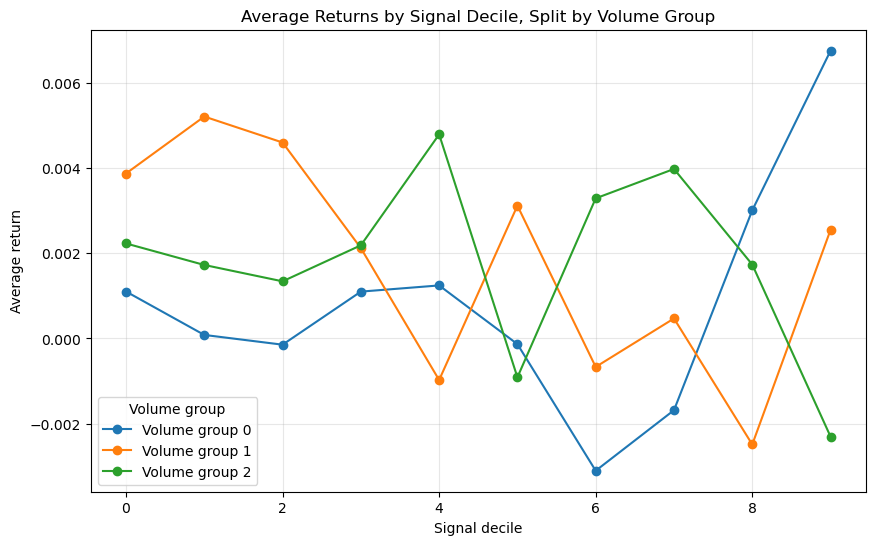

In [9]:

# Compute mean return per (signal decile, volume group)
decile_returns = (
    df.groupby(['volume_decile', 'avgsignal_decile'])['next_returns_funding_volscaled']
      .mean()
      .reset_index()
)

# Plot: return vs signal decile for each volume group
plt.figure(figsize=(10, 6))
for vol_group in sorted(decile_returns['volume_decile'].unique()):
    subset = decile_returns[decile_returns['volume_decile'] == vol_group]
    plt.plot(
        subset['avgsignal_decile'],
        subset['next_returns_funding_volscaled'],
        marker='o',
        label=f'Volume group {vol_group}'
    )

plt.xlabel("Signal decile")
plt.ylabel("Average return")
plt.title("Average Returns by Signal Decile, Split by Volume Group")
plt.legend(title="Volume group")
plt.grid(True, alpha=0.3)
plt.show()

it seems like higher volume assets preform better on longs and lower volume on shorts with the exception of the highest decile - this aligns intuitively too, considering many of the higher volume assets are better quality tokens and have a lower chance of "failing"

the highest decile is where the perp would be (comparitively) most out of line with an oracle price which would mean it is the pump of the day (wouldnt want to be shorting it - at least that day)

going to long the highest two volume groups only and short the bottom two, i am aware this is putting me more into overfitting land but im comfortable with that given the positions i am taking here - longing things that are more reputable and stable and shorting the things that are newer and less traded

In [10]:
# filtering signal by volume
df["final_signal"] = None

for index in df.index:
    if ((df.loc[index, "volume_decile"] in [1, 2]) and (df.loc[index, "avgsignal_decile"] <= 4)):
        df.loc[index, "final_signal"] = df.loc[index, "avgsignal_decile"]

    elif ((df.loc[index, "volume_decile"] in [0, 1]) and (df.loc[index, "avgsignal_decile"] >= 5)):
        df.loc[index, "final_signal"] = df.loc[index, "avgsignal_decile"]

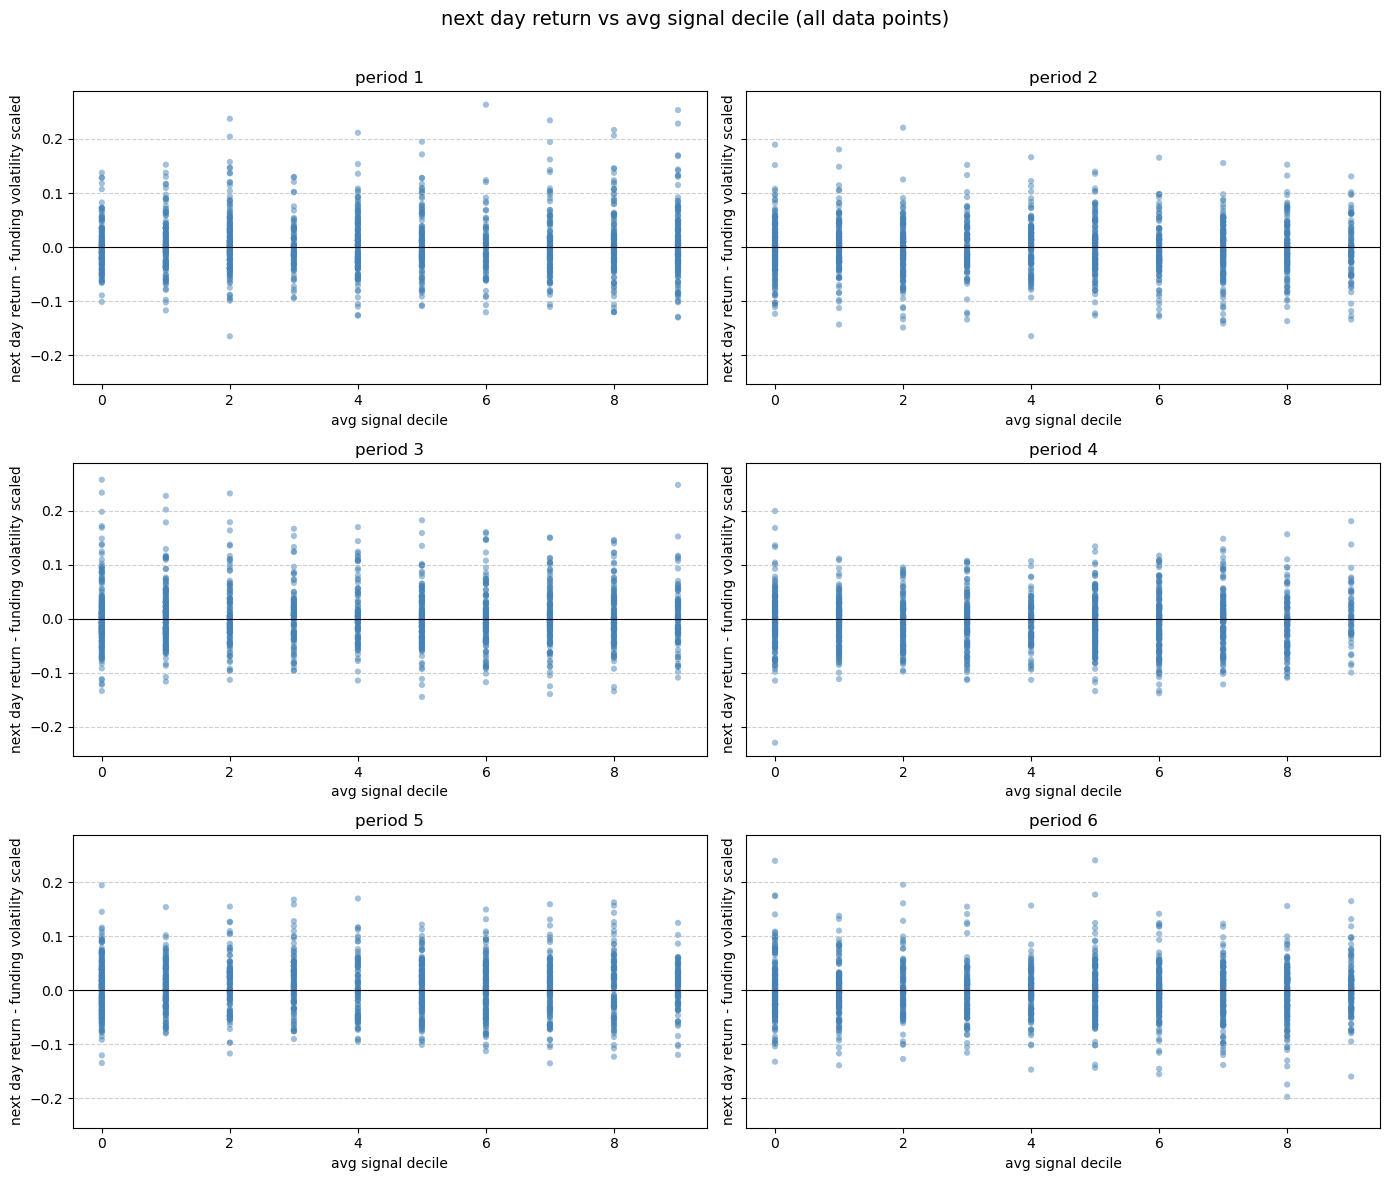

In [11]:
# create subplots (3 rows × 2 columns)
df["period"] = pd.qcut(df["timestamp"].rank(method="first"), 6, labels=False) + 1

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    
    # scatter all data points
    ax.scatter(subset["final_signal"], subset["next_returns_funding_volscaled"], 
               color="steelblue", alpha=0.5, s=20, edgecolor="none")
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("avg signal decile")
    ax.set_ylabel("next day return - funding volatility scaled")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    #ax.set_xticks(sorted(df["final_signal"].unique()))

plt.suptitle("next day return vs avg signal decile (all data points)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

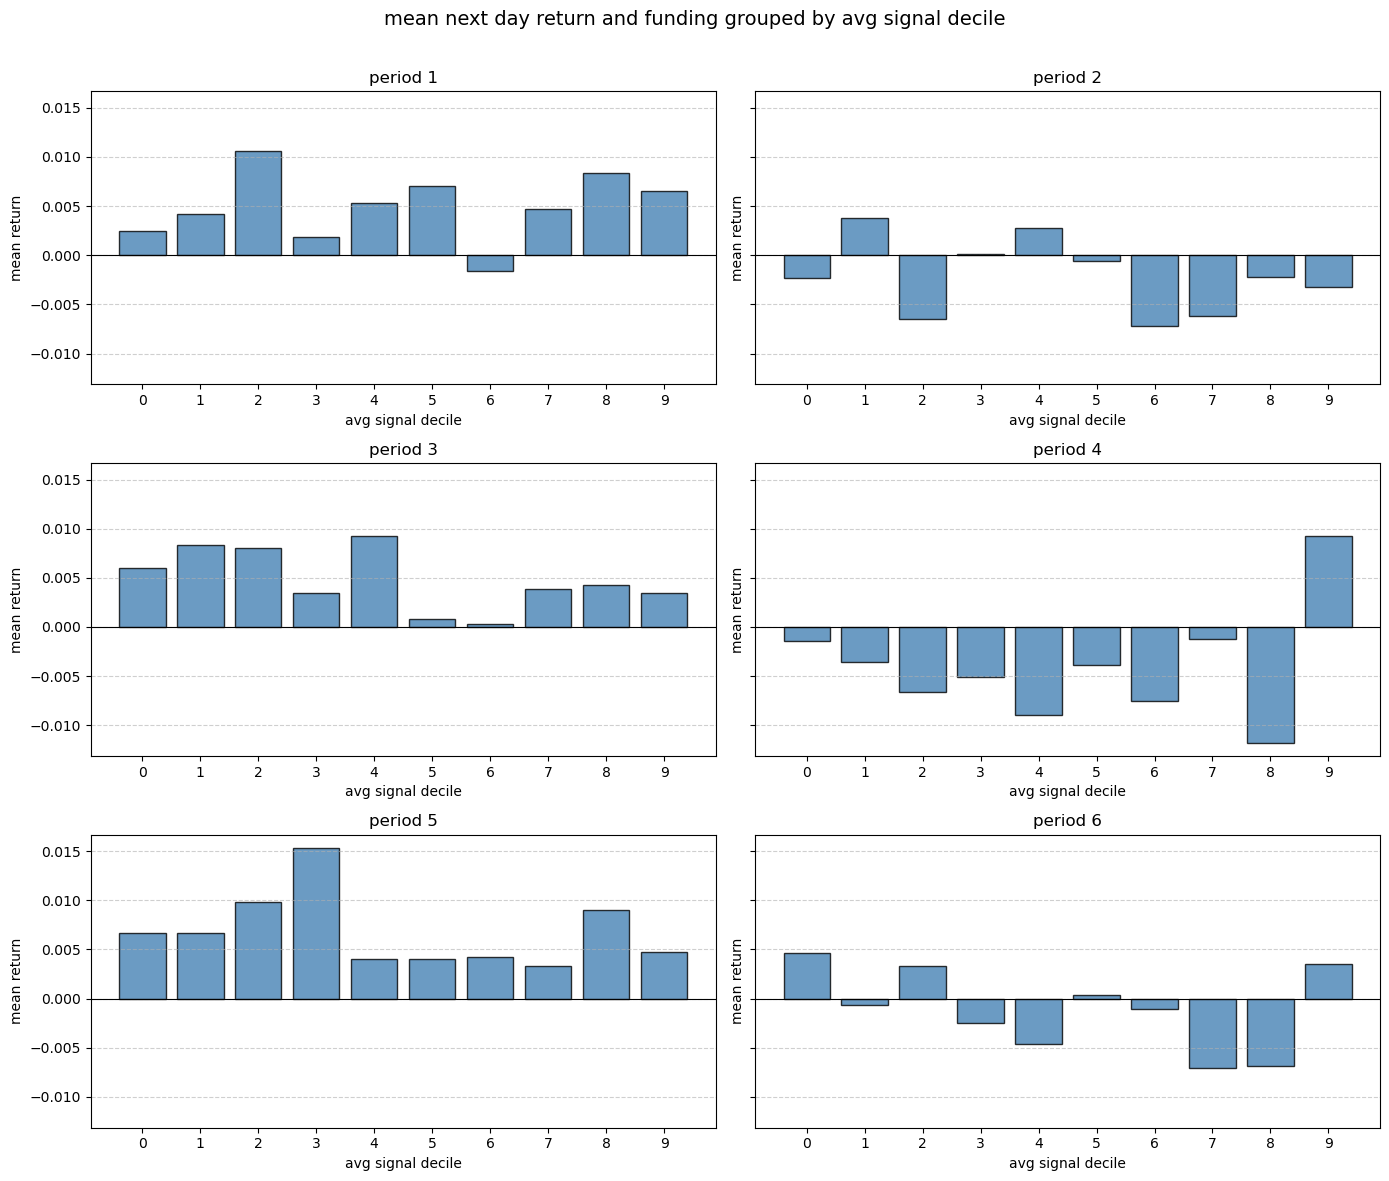

In [12]:
# create subplots (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    decile_means = subset.groupby("final_signal")["next_returns_funding_volscaled"].mean()
    
    bars = ax.bar(decile_means.index, decile_means.values, 
                  color="steelblue", edgecolor="black", alpha=0.8)
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("avg signal decile")
    ax.set_ylabel("mean return")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(decile_means.index)

plt.suptitle("mean next day return and funding grouped by avg signal decile", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

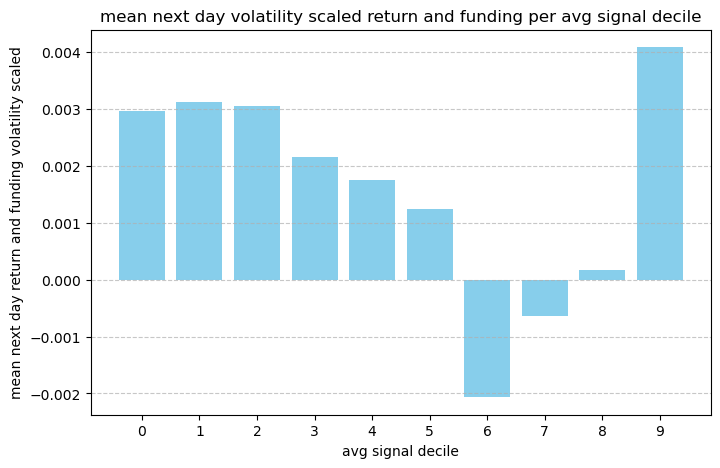

In [13]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("final_signal")["next_returns_funding_volscaled"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("avg signal decile")
plt.ylabel("mean next day return and funding volatility scaled")
plt.title("mean next day volatility scaled return and funding per avg signal decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

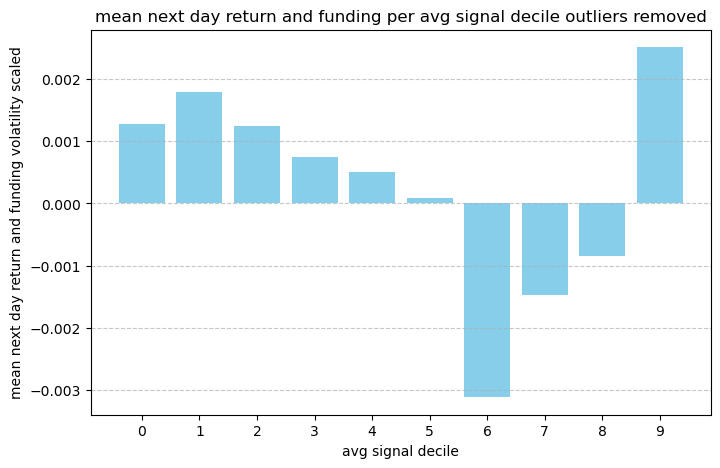

In [14]:
decile_means_v2 = (
    df.groupby("final_signal")["next_returns_funding_volscaled"]
      .apply(lambda g: g[
          (g >= g.quantile(0.05)) &
          (g <= g.quantile(0.95))
      ].mean())
)

plt.figure(figsize=(8,5))
plt.bar(decile_means_v2.index, decile_means_v2.values, color="skyblue")
plt.xlabel("avg signal decile")
plt.ylabel("mean next day return and funding volatility scaled")
plt.title("mean next day return and funding per avg signal decile outliers removed")
plt.xticks(decile_means_v2.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

outliers dont seem to have a meaningful impact on returns in the way we plan to trade it and there doesnt seem to be edge decay either